Telco Customer Churn Feature Engineering
#############################
Problem : You are asked to develop a machine learning model that can predict which customers will leave the company.
expected to perform the necessary data analysis and feature engineering steps before developing the model.

Telco customer churn data contains information about a fictitious telecom company that provided home phone and Internet services to 7,043 customers in California in the third quarter. It includes which customers left, stayed, or signed up for their service.

In [22]:
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [23]:
df = pd.read_csv("/content/Telco-Customer-Churn.csv")
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.65,Yes


In [24]:
#correct type error
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

#"seniorcitizen" değişkenini kategorik yapalım.
df["SeniorCitizen"] = df["SeniorCitizen"].astype(str)


df.isnull().sum()
df.isnull().sum()[df.isnull().sum() > 0]

,0
TotalCharges,11


In [25]:

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Gives the names of categorical, numeric and categorical but cardinal variables in the data set.

    Note: Categorical variables with numeric appearance are also included in categorical variables.

Parameters
------
    dataframe: dataframe
    Dataframe from which variable names are to be taken
    cat_th: int, optional
    Class threshold value for numeric but categorical variables
    car_th: int, optional
    Class threshold value for categorical but cardinal variables

Returns
------
    cat_cols: list
    Categorical variable list
    num_cols: list
    Numeric variable list
    cat_but_car: list
    Cardinal variable list with categorical appearance

Examples
------
    import seaborn as sns
    df = sns.load_dataset("iris")
    print(grab_col_names(df))

Notes
------
    cat_cols + num_cols + cat_but_car = total number of variables
    num_but_cat inside cat_cols.

    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car, num_but_cat


cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)


Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 0


In [26]:
df["TotalCharges"] = df["TotalCharges"].fillna(df["tenure"] * df["MonthlyCharges"])


num_cols = df[num_cols]
cat_cols = df[cat_cols]

       Churn  Ratio
Churn              
No      5174 73.463
Yes     1869 26.537
##########################################


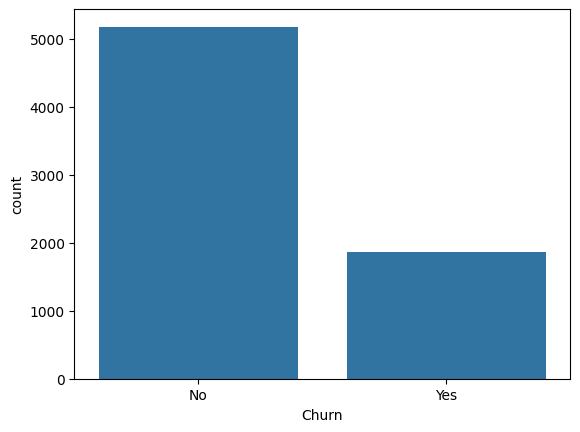

In [27]:
#summary of categorical variable
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

cat_summary(df, "Churn", plot=True)



count   7043.000
mean      32.371
std       24.559
min        0.000
5%         1.000
10%        2.000
20%        6.000
30%       12.000
40%       20.000
50%       29.000
60%       40.000
70%       50.000
80%       60.000
90%       69.000
95%       72.000
99%       72.000
max       72.000
Name: tenure, dtype: float64


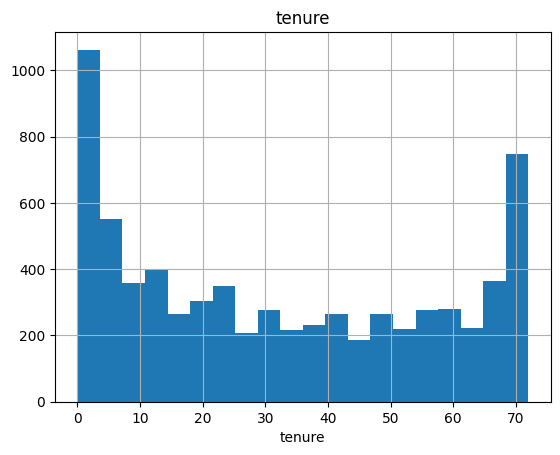

count   7043.000
mean      64.762
std       30.090
min       18.250
5%        19.650
10%       20.050
20%       25.050
30%       45.850
40%       58.830
50%       70.350
60%       79.100
70%       85.500
80%       94.250
90%      102.600
95%      107.400
99%      114.729
max      118.750
Name: MonthlyCharges, dtype: float64


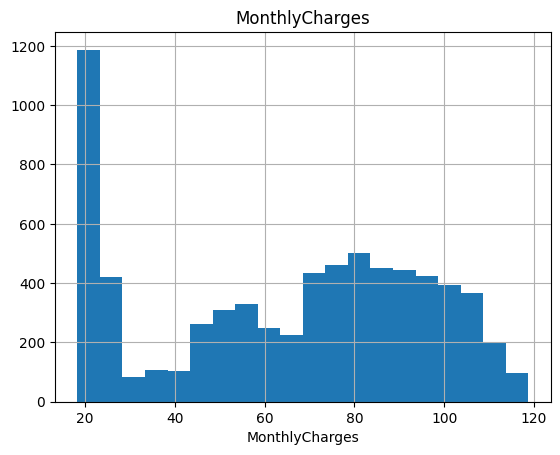

count   7043.000
mean    2279.734
std     2266.794
min        0.000
5%        48.600
10%       83.470
20%      265.320
30%      548.400
40%      939.780
50%     1394.550
60%     2043.710
70%     3132.750
80%     4471.440
90%     5973.690
95%     6921.025
99%     8039.256
max     8684.800
Name: TotalCharges, dtype: float64


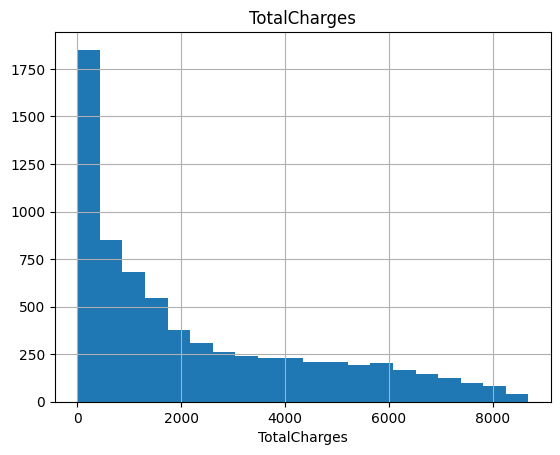

In [28]:
#numerical variable analysis
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(df, col, plot=True)



In [29]:
#cat_cols = df[cat_cols] #if you will run it second time hastag will be added before run it

#categorical değişkenlerin dağılımı görselleştirilir.
cat_cols.columns
for col in cat_cols.columns:
    print(col, ":", cat_cols[col].nunique())
    print(cat_cols[col].value_counts())
    print("____________________")
plt.show()




gender : 2
gender
Male      3555
Female    3488
Name: count, dtype: int64
____________________
SeniorCitizen : 2
SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64
____________________
Partner : 2
Partner
No     3641
Yes    3402
Name: count, dtype: int64
____________________
Dependents : 2
Dependents
No     4933
Yes    2110
Name: count, dtype: int64
____________________
PhoneService : 2
PhoneService
Yes    6361
No      682
Name: count, dtype: int64
____________________
MultipleLines : 3
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64
____________________
InternetService : 3
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64
____________________
OnlineSecurity : 3
OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64
____________________
OnlineBackup : 3
OnlineBackup
No                     30

In [30]:
#Kategorik değişkenler ile hedef değişken incelemesini yapınız.


df.groupby([df["StreamingTV"], "Churn"]).size().unstack()


Churn,No,Yes
StreamingTV,,
No,1868,942
No internet service,1413,113
Yes,1893,814


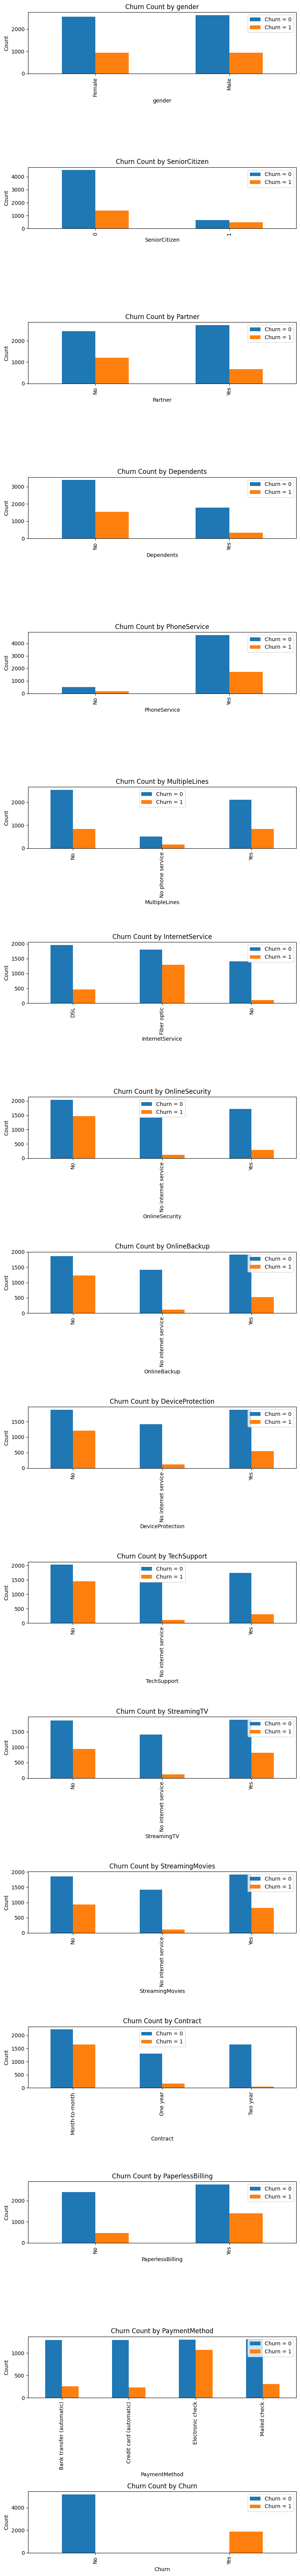

In [31]:

#Visualize categorical variable depend on "churn"
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

# Kategorik değişkenleri belirle
categorical_cols = cat_cols.columns

fig, axes = plt.subplots(nrows=len(categorical_cols), ncols=1, figsize=(8, len(categorical_cols) * 4))

# Görselleştirme
for ax, col in zip(axes, categorical_cols):
    # Churn = 0 ve Churn = 1 olanları ayrı ayrı say
    churn_counts = df.groupby([col, "Churn"]).size().unstack()

    # Yan yana (grouped) barplot
    churn_counts.plot(kind="bar", ax=ax)

    ax.set_title(f"Churn Count by {col}")
    ax.set_ylabel("Count")
    ax.legend(["Churn = 0", "Churn = 1"])

plt.tight_layout()
plt.show()


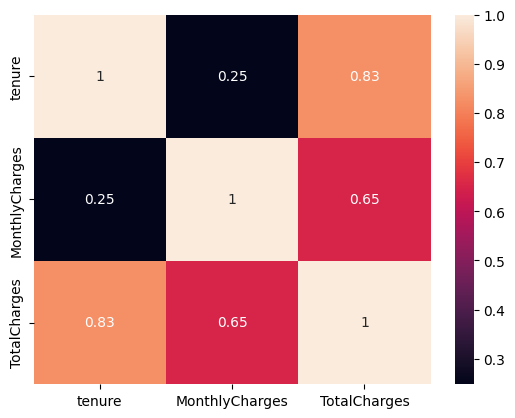

In [32]:
#num_cols = df[num_cols] #if you will run it second time hastag will be added before run it

num_cols.corr()
sns.heatmap(num_cols.corr(), annot=True)
plt.show()



In [33]:

#######FEATURE ENGINEERING######

# outlier analysis
##################################

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


# Analiz fonksiyonu
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


# Aykırı Değer Analizi ve Baskılama İşlemi
for col in num_cols:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)



tenure False
MonthlyCharges False
TotalCharges False


In [34]:

# feature extraction
##################################

# Tenure  değişkeninden yıllık kategorik değişken oluşturma
df.loc[(df["tenure"]>=0) & (df["tenure"]<=12),"NEW_TENURE_YEAR"] = "0-1 Year"
df.loc[(df["tenure"]>12) & (df["tenure"]<=24),"NEW_TENURE_YEAR"] = "1-2 Year"
df.loc[(df["tenure"]>24) & (df["tenure"]<=36),"NEW_TENURE_YEAR"] = "2-3 Year"
df.loc[(df["tenure"]>36) & (df["tenure"]<=48),"NEW_TENURE_YEAR"] = "3-4 Year"
df.loc[(df["tenure"]>48) & (df["tenure"]<=60),"NEW_TENURE_YEAR"] = "4-5 Year"
df.loc[(df["tenure"]>60) & (df["tenure"]<=72),"NEW_TENURE_YEAR"] = "5-6 Year"




# Kişinin toplam aldığı servis sayısı
df['NEW_TotalServices'] = (df[['PhoneService', 'InternetService', 'OnlineSecurity',
                                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                       'StreamingTV', 'StreamingMovies']] == 'Yes').sum(axis=1)



df.head()
df.shape

(7043, 23)

In [35]:

# BASE MODEL KURULUMU
##################################
from sklearn.preprocessing import MinMaxScaler
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

# LABEL ENCODING
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
binary_cols

for col in binary_cols:
    df = label_encoder(df, col)


# cat_cols list updated
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Churn"]]
cat_cols

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
df = one_hot_encoder(df, cat_cols, drop_first=True)


scaler = MinMaxScaler()

# scale just numerical columns
df[num_cols] = scaler.fit_transform(df[num_cols])


Observations: 7043
Variables: 23
cat_cols: 19
num_cols: 3
cat_but_car: 1
num_but_cat: 1


In [42]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

y = df["Churn"]
X = df.drop(["Churn", "customerID"], axis=1)
#print(y)
X.isnull().sum()
models = [('LR', LogisticRegression()),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier()),
          ('RF', RandomForestClassifier(class_weight='balanced')),
          ('XGB', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))]

for name, model in models:
    cv_results = cross_validate(model, X, y, cv=3, scoring=["accuracy", "f1", "roc_auc", "precision", "recall"])
    print(f"########## {name} ##########")
    print(f"Accuracy: {round(cv_results['test_accuracy'].mean(), 4)}")
    print(f"Auc: {round(cv_results['test_roc_auc'].mean(), 4)}")
    print(f"Recall: {round(cv_results['test_recall'].mean(), 4)}")
    print(f"Precision: {round(cv_results['test_precision'].mean(), 4)}")
    print(f"F1: {round(cv_results['test_f1'].mean(), 4)}")



########## LR ##########
Accuracy: 0.8024
Auc: 0.8452
Recall: 0.5174
Precision: 0.6637
F1: 0.5815
########## KNN ##########
Accuracy: 0.7595
Auc: 0.7681
Recall: 0.5147
Precision: 0.5499
F1: 0.5316
########## CART ##########
Accuracy: 0.7223
Auc: 0.6552
Recall: 0.5099
Precision: 0.4783
F1: 0.4934
########## RF ##########
Accuracy: 0.7906
Auc: 0.8223
Recall: 0.4655
Precision: 0.6469
F1: 0.5412
########## XGB ##########
Accuracy: 0.7821
Auc: 0.8152
Recall: 0.5072
Precision: 0.6073
F1: 0.5525


In [38]:

#upload for train test split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5)

rf_model = RandomForestClassifier(class_weight='balanced', random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)


print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")
############## LOGISTIC REGRESSION MODEL ######################
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression(random_state=46).fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")
#RF
#Accuracy: 0.8
#Recall: 0.671
#Precision: 0.5
#F1: 0.57
#Auc: 0.75

#logistic regression result
#Accuracy: 0.8
#Recall: 0.667
#Precision: 0.53
#F1: 0.59
#Auc: 0.75



Accuracy: 0.79
Recall: 0.657
Precision: 0.46
F1: 0.54
Auc: 0.74
Accuracy: 0.8
Recall: 0.674
Precision: 0.5
F1: 0.58
Auc: 0.75


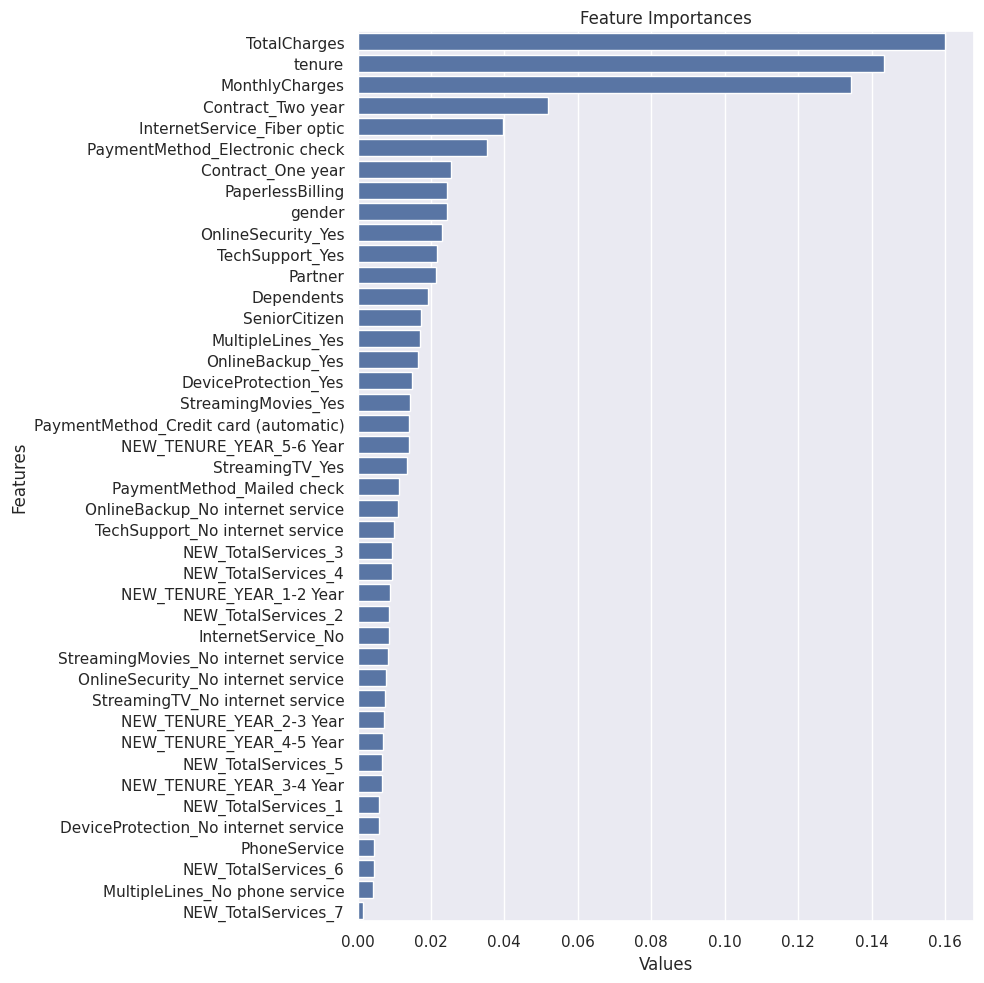

In [41]:
#FEATURE IMPORTANCE
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Values': model.feature_importances_, 'Features': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Values", y="Features", data=feature_imp.sort_values(by="Values",
                                                                     ascending=False)[0:num])
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, X)

In [46]:
# Select a random row from the dataset (representing a random user)
random_user_data = X.sample(11)  # Select 11 random row from X (features)

# Get the churn probability using predict_proba
churn_probability = rf_model.predict_proba(random_user_data)[0][1]

# Print the churn probability
print(f"The churn probability for the random user is: {churn_probability:.4f}")

The churn probability for the random user is: 0.6600
